In [1]:
%%capture
!pip install -U git+https://github.com/qubvel-org/segmentation_models.pytorch
!pip install lightning albumentations

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader

In [17]:
def preprocess_mask(mask_path):
    """
    Converte máscaras RGB para máscaras binárias

    Args:
    - mask_path: caminho para o arquivo de máscara

    Returns:
    - Máscara binária como tensor
    """

    # Abrir a máscara
    mask = Image.open(mask_path)

    # Converter para numpy array
    mask_array = np.array(mask)

    # Criar máscara binária
    # Assumindo que valores diferentes de 0 indicam área segmentada
    binary_mask = (mask_array[:,:,0] > 0).astype(np.float32)

    # Converter para tensor
    binary_mask_tensor = torch.from_numpy(binary_mask).unsqueeze(0)

    return binary_mask_tensor

In [23]:
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import torch
from PIL import Image
import torchvision.transforms.functional as F

class WildFires(Dataset):
    def __init__(self, root, split, transform=None):
        self.root = root
        self.split = split
        self.transform = transform
        self.images_dir = os.path.join(root, split, 'images')
        self.masks_dir = os.path.join(root, split, 'masks')
        self.image_filenames = sorted(os.listdir(self.images_dir))
        self.mask_filenames = sorted(os.listdir(self.masks_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert('RGB')

        mask = preprocess_mask(mask_path)

        if self.transform:
          image = self.transform(image)

        if self.transform:
          mask = F.resize(mask, size=image.shape[1:], interpolation=F.InterpolationMode.NEAREST)

        return {'image': image, 'mask': mask}

# Configurações de transformações
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])



## Dataset

Train size: 281
Valid size: 53
Test size: 99


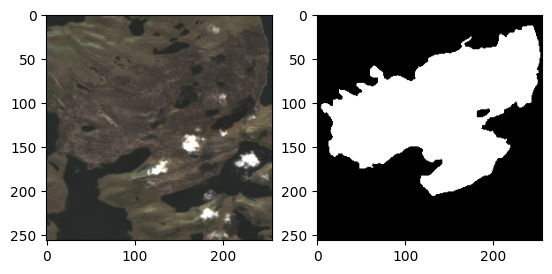

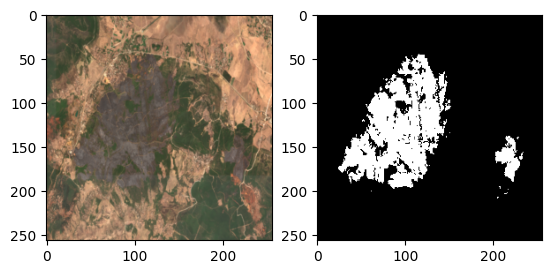

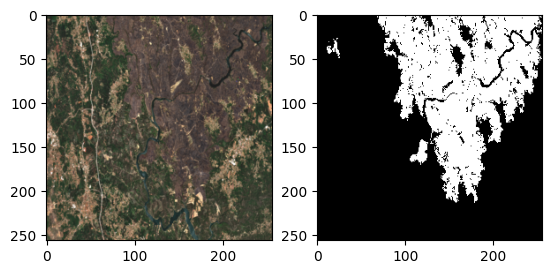

Train size: 281
Valid size: 53
Test size: 99


In [24]:
# Inicializa os datasets
root = '/content/drive/MyDrive/wildfires_v2'
train_dataset = WildFires(root, 'train', transform=transform)
valid_dataset = WildFires(root, 'val', transform=transform)
test_dataset = WildFires(root, 'test', transform= transform)

# Garantir que os conjuntos não se intersectam
assert set(os.listdir(os.path.join(root, 'train', 'images'))).isdisjoint(set(os.listdir(os.path.join(root, 'val', 'images'))))
assert set(os.listdir(os.path.join(root, 'train', 'images'))).isdisjoint(set(os.listdir(os.path.join(root, 'test', 'images'))))
assert set(os.listdir(os.path.join(root, 'val', 'images'))).isdisjoint(set(os.listdir(os.path.join(root, 'test', 'images'))))

# Carregadores de dados
n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=n_cpu)

# Visualização dos dados
def visualize_sample(dataset, idx):
    sample = dataset[idx]
    plt.subplot(1, 2, 1)
    plt.imshow(sample['image'].permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(sample['mask'].squeeze(), cmap='gray')
    plt.show()

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Exemplo de visualização
visualize_sample(train_dataset, 0)
visualize_sample(valid_dataset, 0)
visualize_sample(test_dataset, 0)

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=n_cpu
)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=n_cpu
)
test_dataloader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=n_cpu
)

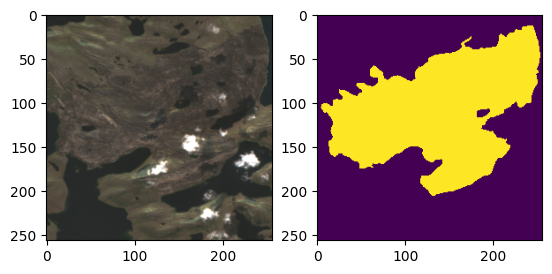

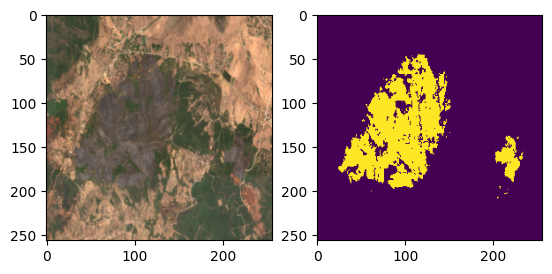

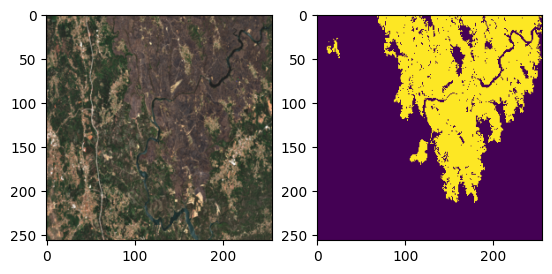

In [25]:
# lets look at some samples

import matplotlib.pyplot as plt

# Exibindo uma amostra do conjunto de treino
sample = train_dataset[0]
plt.subplot(1, 2, 1)
plt.imshow(sample["image"].permute(1, 2, 0).cpu().numpy())  # Converte para HWC
plt.subplot(1, 2, 2)
plt.imshow(sample["mask"].squeeze().cpu().numpy())  # Remove a dimensão extra
plt.show()

# Conjunto de validação
sample = valid_dataset[0]
plt.subplot(1, 2, 1)
plt.imshow(sample["image"].permute(1, 2, 0).cpu().numpy())
plt.subplot(1, 2, 2)
plt.imshow(sample["mask"].squeeze().cpu().numpy())
plt.show()

# Conjunto de teste
sample = test_dataset[0]
plt.subplot(1, 2, 1)
plt.imshow(sample["image"].permute(1, 2, 0).cpu().numpy())
plt.subplot(1, 2, 2)
plt.imshow(sample["mask"].squeeze().cpu().numpy())
plt.show()


## Model

In [26]:
# Some training hyperparameters
EPOCHS = 10
T_MAX = EPOCHS * len(train_dataloader)
OUT_CLASSES = 1

In [27]:
class Model(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

In [28]:
model = Model("FPN", "resnet34", in_channels=3, out_classes=1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

## Training

In [29]:
trainer = pl.Trainer(max_epochs=EPOCHS,log_every_n_steps=1)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 23.2 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)
175       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


## Validation and test metrics

In [30]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
print(valid_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_per_image_iou': 0.378090500831604, 'valid_dataset_iou': 0.5420079827308655}]


In [31]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_per_image_iou': 0.37675267457962036, 'test_dataset_iou': 0.5441516041755676}]


# Result visualization

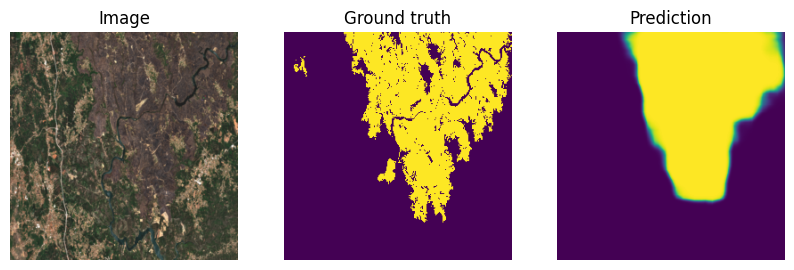

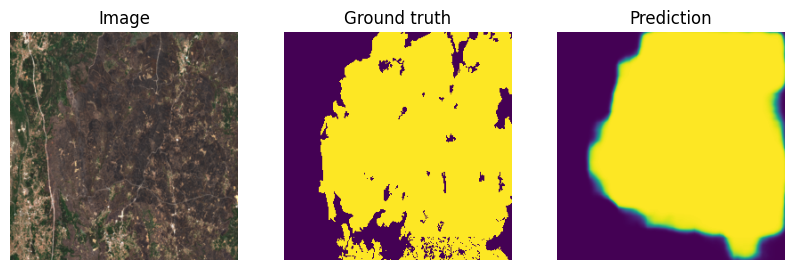

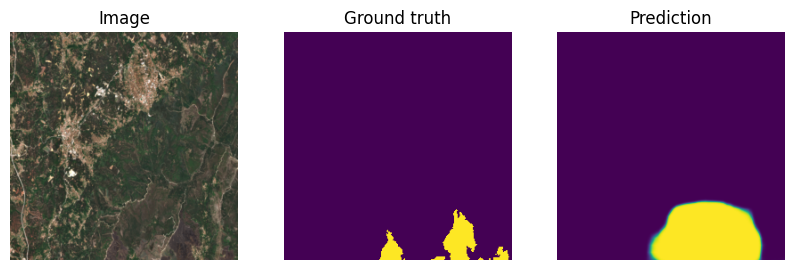

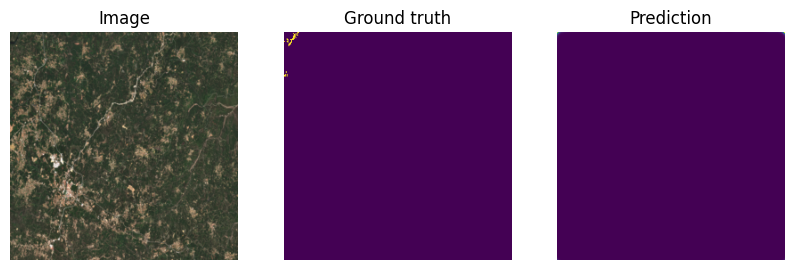

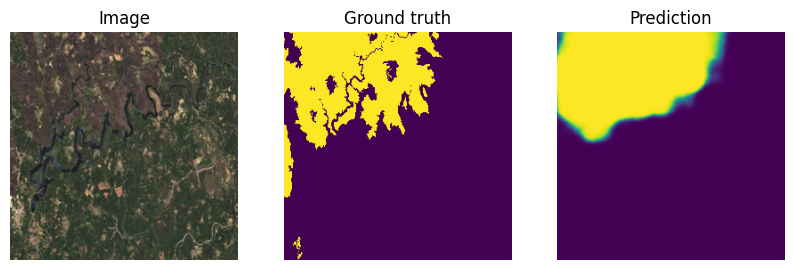

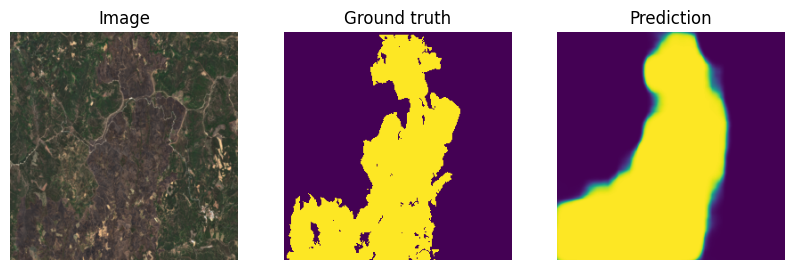

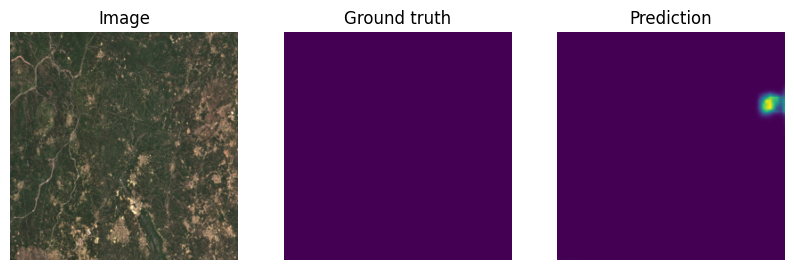

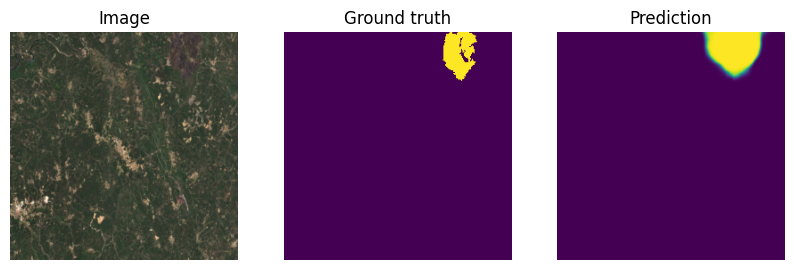

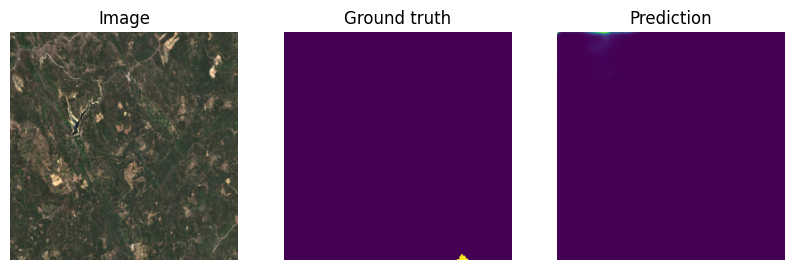

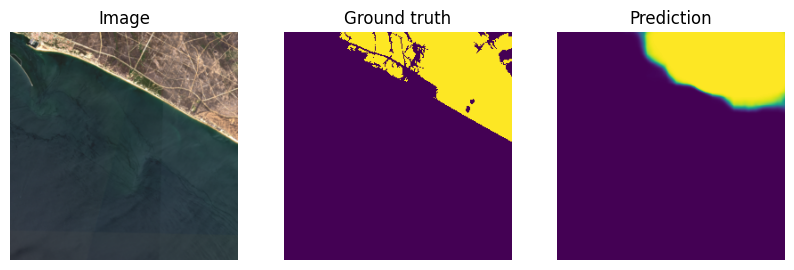

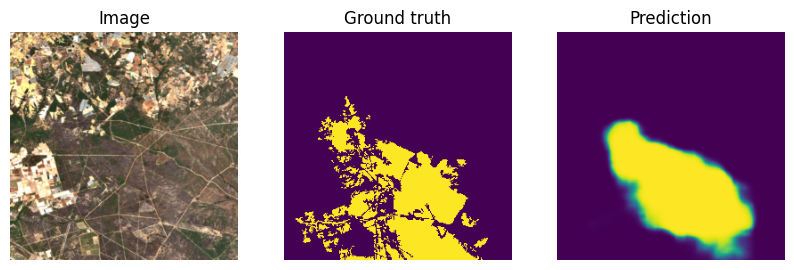

In [32]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch["image"], batch["mask"], pr_masks)
):
    if idx <= 10:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break